### Упражнение 1
* Реализуйте функцию `get_geodesic_distance`, рассчитывающее геодезическое расстояние между двумя точками в километрах.

In [1]:
import math
from shapely.geometry import Point

def get_geodesic_distance(point1, point2):
    R = 6371  # Радиус земли в км
    lat1 = point1.x
    lon1 = point1.y
    lat2 = point2.x
    lon2 = point2.y
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [2]:
# Сигнатура функции и пример вывода:

mipt = Point(55.9297243, 37.5199434) 
kremlin = Point(55.752023, 37.6174994)

get_geodesic_distance(mipt, kremlin)

20.676951995783718

### Упражнение 2

* Реализуйте функцию `get_k_nearest_neighbours_by_dist`, осуществляющую поиск `k` ближайших соседей полигона из заданного списка на основе геодезического расстояния. Добавьте две возможности учета расстояния: через ближайшие точки на границах полигонов и через центроиды полигонов.

In [3]:
from shapely.ops import nearest_points
import geopandas as gpd
import random
import pandas as pd

def get_k_nearest_neighbours_by_dist(polygon, polygons, k, kind):
    data = []
    if kind == 'by_centroid':
        for i in polygons:
            distance = get_geodesic_distance(polygon.centroid, i.centroid)
            data.append([distance, i])
    elif kind == 'by_board':
        for i in polygons:
            point1, point2 = nearest_points(polygon.boundary, i.boundary)
            distance = get_geodesic_distance(point1, point2)
            data.append([distance, i])
    return pd.DataFrame(sorted(data, key=lambda i: i[0])[:k], columns=['dist', 'geometry'])

In [4]:
# Сигнатура функции и пример вывода:

big_moscow_districts = gpd.read_file('../data/big_moscow_disticts/big_moscow_districts.shp')
polygon = random.sample(big_moscow_districts['geometry'].tolist(), 1)[0]
polygons = random.sample(big_moscow_districts['geometry'].tolist(), 50)

k_nearest_neighbours_by_board = get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_board')
k_nearest_neighbours_by_centroid = get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_centroid')
k_nearest_neighbours_by_centroid

,dist,geometry
0,3.747688,"POLYGON ((37.50654280000001 55.6617784, 37.501..."
1,6.714460,"POLYGON ((37.36538820000001 55.77181210000001,..."
2,6.872488,"POLYGON ((37.4891568 55.6107185, 37.488875 55...."
3,7.234519,"POLYGON ((37.52039510000001 55.6343194, 37.520..."
4,7.328751,"POLYGON ((37.5219435 55.761509, 37.5218309 55...."
5,7.596998,"POLYGON ((37.5592321 55.7102802, 37.5570246999..."
6,8.550190,"POLYGON ((37.5551274 55.6706481, 37.554312 55...."
7,8.616313,(POLYGON ((37.37720419999999 55.72907980000001...
8,10.107542,"POLYGON ((37.456838 55.64031870000001, 37.4568..."
9,10.310891,"POLYGON ((37.5639978 55.6494629, 37.5633760000..."


In [5]:
# Сигнатура функции и пример вывода:

big_moscow_districts = gpd.read_file('../data/big_moscow_disticts/big_moscow_districts.shp')
polygon = random.sample(big_moscow_districts['geometry'].tolist(), 1)[0]
polygons = random.sample(big_moscow_districts['geometry'].tolist(), 50)

k_nearest_neighbours_by_board = get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_board')
k_nearest_neighbours_by_centroid = get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_centroid')
k_nearest_neighbours_by_centroid

,dist,geometry
0,2.841250,"POLYGON ((37.74593050000001 55.8103596, 37.746..."
1,4.309704,"POLYGON ((37.7364842 55.74585560000001, 37.736..."
2,4.962520,"POLYGON ((37.7054964 55.79279540000001, 37.705..."
3,5.756742,"POLYGON ((37.76713240000001 55.73435820000001,..."
4,6.339555,"POLYGON ((37.7133277 55.77547930000001, 37.713..."
5,6.407552,"POLYGON ((37.80870090000001 55.7602404, 37.808..."
6,7.938096,"POLYGON ((37.69983530000001 55.73631690000001,..."
7,8.112059,"POLYGON ((37.75611880000001 55.69136990000001,..."
8,8.539718,"POLYGON ((37.7774058 55.85644189999999, 37.782..."
9,9.592425,"POLYGON ((37.6719431 55.85042539999999, 37.671..."


In [6]:
import matplotlib.pyplot as plt

k_nearest_neighbours_by_centroid = gpd.GeoSeries(list(k_nearest_neighbours_by_centroid['geometry']))
k_nearest_neighbours_by_board = gpd.GeoSeries(list(k_nearest_neighbours_by_board['geometry']))

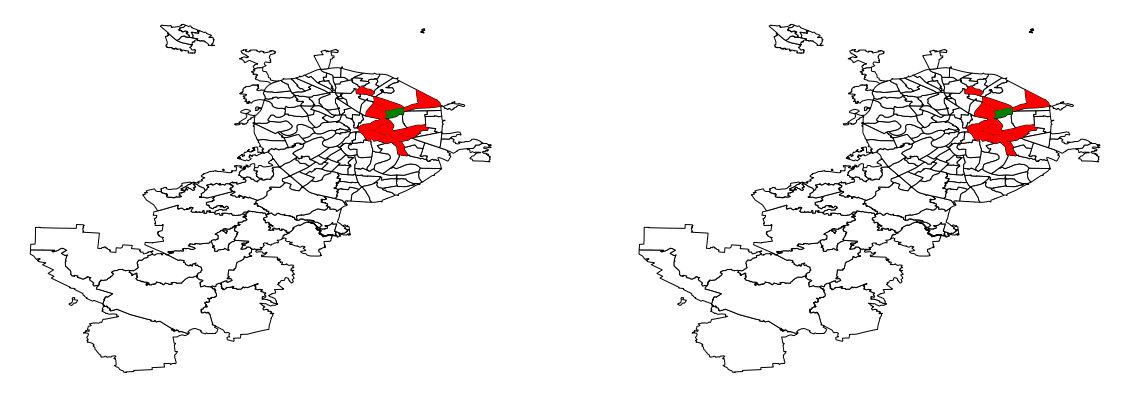

In [7]:
###

fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
k_nearest_neighbours_by_centroid.plot(ax=ax, color='red')
gpd.GeoSeries(polygon).plot(ax=ax, color='green')
ax.set_axis_off()

ax = plt.subplot(1, 2, 2)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
k_nearest_neighbours_by_board.plot(ax=ax, color='red')
gpd.GeoSeries(polygon).plot(ax=ax, color='green')
ax.set_axis_off()

### Упражнение 3 (*)
* Реализуйте функцию `spatial_resample`, выполняющую пространственное агрегирование. 
  На вход функция принимает:
  - `init_polygons` - изначальное гео-разбиение
  - `agg_polygons` - новое гео-разбиение, по которому будет проводится пространственное агрегирование
  - `column` - название столбца количественной переменной в `init_polygons`, которая будет агрегирована  
  - `method` - метод аггрегирования: `sum` - сумма значений, `mean` - среднее значение
  - `kind` - способ аггрегирования при частичном пересечении полигонов из `agg_polygons` и `init_polygons`, `max` - отнести значение в `column` к полигону из `agg_polygons` с которым площадь пересечения максимальна, `prop` - разбить значение в `column` пропорционально площадям пересечений

In [4]:
# Сигнатура функции и пример вывода:

grid_big_moscow = gpd.read_file('../data/grid_big_moscow.shp')
grid_big_moscow.crs = "EPSG:4326"  
grid_big_moscow['random_value'] = np.random.randint(0, 100, len(grid_big_moscow))

mean_resample_table = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='mean', column='random_value', kind='max')
sum_resample_table = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='sum', column='random_value', kind='max')
mean_resample_table.head()

,agg_index,geometry,random_value
0,0,"POLYGON ((37.68525 55.89508, 37.68891 55.89504...",49.814815
1,1,"POLYGON ((37.60716 55.87932, 37.60754 55.87911...",47.923077
2,2,"POLYGON ((37.64437 55.89768, 37.65226 55.89678...",45.807692
3,3,"POLYGON ((37.49625 55.89248, 37.49851 55.89347...",58.322581
4,4,"POLYGON ((37.41143 55.87096, 37.40632 55.87426...",46.446809


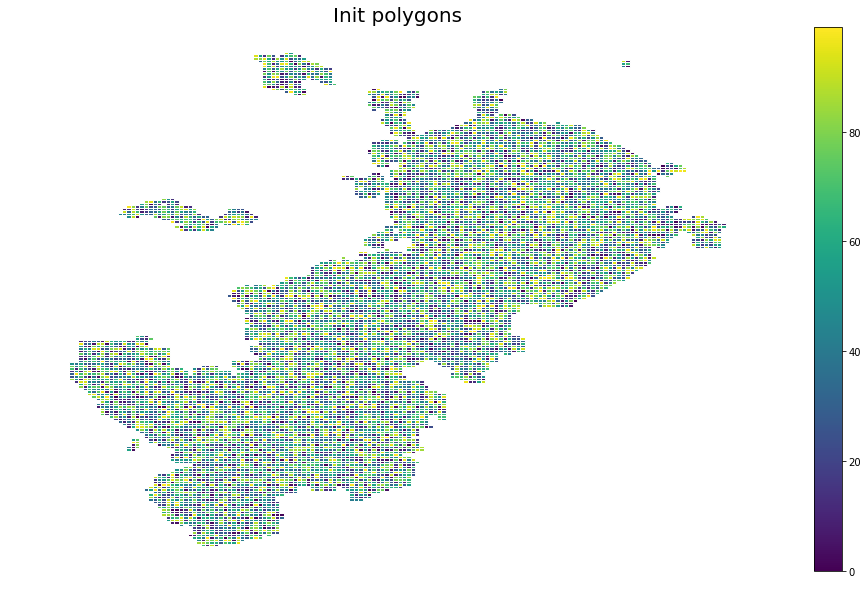

In [5]:
fig = plt.figure(figsize=(20, 10))
plt.title('Init polygons', fontsize=20)
ax = plt.gca()
grid_big_moscow.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

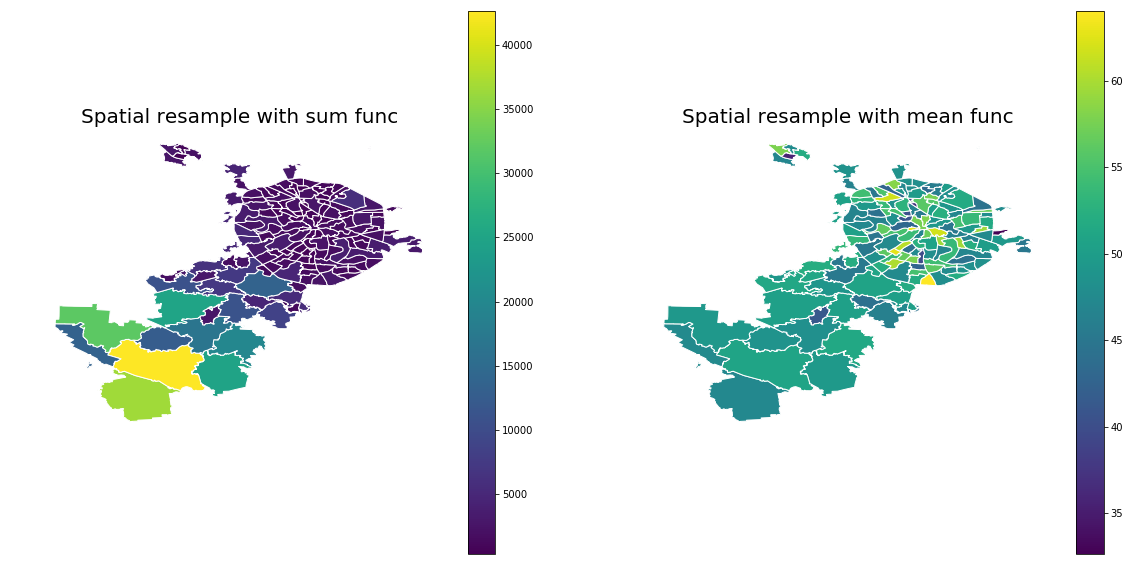

In [6]:
###

fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
plt.title('Spatial resample with sum func', fontsize=20)
sum_resample_table.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

ax = plt.subplot(1, 2, 2)
plt.title('Spatial resample with mean func', fontsize=20)
mean_resample_table.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

### Упражнение 4
* Отобразите результаты упражнений 2 и 3 (рисунки с `###`) на интерактивной карте в `Folium`